In [2]:
import os
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import xgboost as xgb
from pathlib import Path

In [3]:

def read_all_csv_files(base_path):
    """
    Read all CSV files from subdirectories and combine into a single DataFrame
    
    Parameters:
    base_path (str): Path to the main folder containing subfolders with CSV files
    
    Returns:
    pd.DataFrame: Combined DataFrame containing all CSV data
    """
    
    # Convert to Path object for easier handling
    base_path = Path(base_path)
    
    # List to store individual dataframes
    dfs = []
    
    # Counter for tracking files
    file_count = 0
    
    # Iterate through all subdirectories
    for folder in base_path.iterdir():
        if folder.is_dir():
            print(f"Processing folder: {folder.name}")
            
            # Get all CSV files in this folder
            csv_files = list(folder.glob("*.csv"))
            
            # Read each CSV file
            for csv_file in csv_files:
                try:
                    # Read CSV file, treating various NAN representations as null
                    temp_df = pd.read_csv(csv_file, na_values=['NAN', ' NAN', 'nan', ' nan', 'NaN', ' NaN'])
                    
                    # Optional: Add a column to track which file/folder the data came from
                    temp_df['source_folder'] = folder.name
                    temp_df['source_file'] = csv_file.name
                    
                    dfs.append(temp_df)
                    file_count += 1
                    print(f"  ✓ Loaded: {csv_file.name} ({len(temp_df)} rows)")
                    
                except Exception as e:
                    print(f"  ✗ Error reading {csv_file.name}: {str(e)}")
    
    # Combine all dataframes
    if dfs:
        df = pd.concat(dfs, ignore_index=True)
        print(f"\n{'='*60}")
        print(f"Total files processed: {file_count}")
        print(f"Total rows in combined DataFrame: {len(df)}")
        print(f"Total columns: {len(df.columns)}")
        print(f"{'='*60}")
        return df
    else:
        print("No CSV files found!")
        return pd.DataFrame()


# Main execution
if __name__ == "__main__":
    # Specify the base path
    base_path = r"/home/project/mithlesh/battery_alt_dataset"
    
    # Read all CSV files and combine into DataFrame
    df = read_all_csv_files(base_path)
    
    

Processing folder: regular_alt_batteries
  ✓ Loaded: battery31.csv (3341603 rows)
  ✓ Loaded: battery52.csv (1510563 rows)
  ✓ Loaded: battery01.csv (4918193 rows)
  ✓ Loaded: battery40.csv (753257 rows)
  ✓ Loaded: battery51.csv (1822787 rows)


/tmp/ipykernel_785617/3936661260.py:33: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_file, na_values=['NAN', ' NAN', 'nan', ' nan', 'NaN', ' NaN'])


  ✓ Loaded: battery30.csv (597316 rows)
  ✓ Loaded: battery00.csv (1101244 rows)
  ✓ Loaded: battery21.csv (530718 rows)
  ✓ Loaded: battery10.csv (907341 rows)


/tmp/ipykernel_785617/3936661260.py:33: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_file, na_values=['NAN', ' NAN', 'nan', ' nan', 'NaN', ' NaN'])


  ✓ Loaded: battery22.csv (2690545 rows)
  ✓ Loaded: battery23.csv (1344130 rows)
  ✓ Loaded: battery41.csv (2926443 rows)
  ✓ Loaded: battery50.csv (791869 rows)
  ✓ Loaded: battery11.csv (4914864 rows)
  ✓ Loaded: battery20.csv (207391 rows)
Processing folder: recommissioned_batteries
  ✓ Loaded: battery25.csv (2169910 rows)
  ✓ Loaded: battery24.csv (3285619 rows)
  ✓ Loaded: battery32.csv (1829938 rows)
  ✓ Loaded: battery53.csv (1139972 rows)


/tmp/ipykernel_785617/3936661260.py:33: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_df = pd.read_csv(csv_file, na_values=['NAN', ' NAN', 'nan', ' nan', 'NaN', ' NaN'])


  ✓ Loaded: battery03.csv (2161444 rows)
  ✓ Loaded: battery33.csv (2353426 rows)
  ✓ Loaded: battery12.csv (3041084 rows)
  ✓ Loaded: battery02.csv (2069667 rows)
Processing folder: second_life_batteries
  ✓ Loaded: battery54.csv (1989458 rows)
  ✓ Loaded: battery13.csv (1736149 rows)
  ✓ Loaded: battery36.csv (3394365 rows)

Total files processed: 26
Total rows in combined DataFrame: 53529296
Total columns: 12


In [4]:



def create_featured_dataset(df):
    """
    Create featured dataset with selected columns and their derivatives
    
    Parameters:
    df (pd.DataFrame): Original combined DataFrame
    
    Returns:
    pd.DataFrame: Featured dataset with derivatives
    """
    
    # Select required columns
    selected_cols = ['mode', 'voltage_charger', 'temperature_battery', 
                     'voltage_load', 'current_load', 'temperature_mosfet', 
                     'temperature_resistor']
    
    featured_df = df[selected_cols].copy()
    
    # Convert all columns except mode to float
    print("\nConverting columns to numeric...")
    for col in selected_cols:
        if col != 'mode':
            # Check for non-numeric values before conversion
            original_nulls = featured_df[col].isna().sum()
            
            # Convert to numeric, coercing errors to NaN
            featured_df[col] = pd.to_numeric(featured_df[col], errors='coerce')
            
            # Check for new nulls after conversion
            new_nulls = featured_df[col].isna().sum()
            converted_nulls = new_nulls - original_nulls
            
            if converted_nulls > 0:
                print(f"  ⚠ {col}: {converted_nulls} non-numeric values converted to NaN")
            else:
                print(f"  ✓ Converted {col} to float")
    
    # Convert mode to int (it should be 0, -1, or 1)
    featured_df['mode'] = pd.to_numeric(featured_df['mode'], errors='coerce').astype('Int64')
    print(f"  ✓ Converted mode to int")
    
    # Define columns for derivative calculation (all except mode)
    derivative_cols = ['voltage_charger', 'temperature_battery', 
                       'voltage_load', 'current_load', 
                       'temperature_mosfet', 'temperature_resistor']
    
    print("\nCalculating derivatives...")
    
    # Calculate derivatives for each column
    for col in derivative_cols:
        derivative_col_name = f'{col}_derivative'
        
        # Calculate difference (current - previous)
        featured_df[derivative_col_name] = featured_df[col].diff()
        
        # Handle mode-specific nulls for discharge-only features
        if col in ['voltage_load', 'current_load', 'temperature_mosfet', 'temperature_resistor']:
            # When mode is 0 or 1, these features and their derivatives should be null
            mask = (featured_df['mode'] == 0) | (featured_df['mode'] == 1)
            featured_df.loc[mask, derivative_col_name] = None
        
        print(f"  ✓ Calculated derivative for: {col}")
    
    # Drop rows where previous row was null (first row and rows after null values)
    # This is handled by diff() which sets NaN for first row
    # Now we need to remove rows where the derivative is NaN due to previous null values
    
    initial_rows = len(featured_df)
    
    # For each derivative column, if original value is not null but derivative is null,
    # it means previous row was null - drop these rows
    rows_to_drop = []
    
    for col in derivative_cols:
        derivative_col_name = f'{col}_derivative'
        
        # Find rows where current value is not null but derivative is NaN
        # (excluding intentional nulls for discharge-only features based on mode)
        if col in ['voltage_load', 'current_load', 'temperature_mosfet', 'temperature_resistor']:
            # Only check when mode = -1 (discharge mode)
            mask = (featured_df['mode'] == -1) & \
                   (featured_df[col].notna()) & \
                   (featured_df[derivative_col_name].isna())
        else:
            # For charger and battery features, check all modes
            mask = (featured_df[col].notna()) & \
                   (featured_df[derivative_col_name].isna())
        
        rows_to_drop.extend(featured_df[mask].index.tolist())
    
    # Drop duplicate indices and remove rows
    rows_to_drop = list(set(rows_to_drop))
    featured_df = featured_df.drop(rows_to_drop)
    
    rows_dropped = initial_rows - len(featured_df)
    
    print(f"\nRows dropped due to null previous values: {rows_dropped}")
    print(f"Final featured dataset shape: {featured_df.shape}")
    
    # Display summary of null values
    print("\nNull value summary:")
    print(featured_df.isnull().sum())
    
    return featured_df

In [5]:
featured_df=create_featured_dataset(df)


Converting columns to numeric...
  ✓ Converted voltage_charger to float
  ⚠ temperature_battery: 184 non-numeric values converted to NaN
  ✓ Converted voltage_load to float
  ✓ Converted current_load to float
  ✓ Converted temperature_mosfet to float
  ✓ Converted temperature_resistor to float
  ✓ Converted mode to int

Calculating derivatives...
  ✓ Calculated derivative for: voltage_charger
  ✓ Calculated derivative for: temperature_battery
  ✓ Calculated derivative for: voltage_load
  ✓ Calculated derivative for: current_load
  ✓ Calculated derivative for: temperature_mosfet
  ✓ Calculated derivative for: temperature_resistor

Rows dropped due to null previous values: 9951
Final featured dataset shape: (53519345, 13)

Null value summary:
mode                                      0
voltage_charger                           0
temperature_battery                     183
voltage_load                       46167258
current_load                       46167258
temperature_mosfet          

In [6]:
# Drop rows where temperature_battery is null
featured_df = featured_df.dropna(subset=["temperature_battery"])


In [7]:
featured_df[featured_df['voltage_charger'] >8.5].shape

(3687917, 13)

In [8]:
featured_df.shape

(53519162, 13)

In [9]:
low = featured_df['voltage_charger_derivative'].quantile(0.1)   # 0th percentile (min)
high = featured_df['voltage_charger_derivative'].quantile(0.05) # 99th percentile

print("Range: ", low, "to", high)


Range:  -0.0010000000000012221 to -0.0030000000000001137


In [10]:
low = featured_df["temperature_battery_derivative"].quantile(0.95)   # 0th percentile (min)
high = featured_df["temperature_battery_derivative"].quantile(0.99) # 99th percentile

print("Range: ", low, "to", high)


Range:  0.0660000000000025 to 0.14000000000000057


In [3]:
from sklearn.ensemble import IsolationForest
import numpy as np

In [12]:
featured_df.to_csv("featured_df.csv")


In [13]:


def label_anomalies(featured_df):
    """
    Label anomalies using Isolation Forest and hardcoded rules
    
    Parameters:
    featured_df (pd.DataFrame): Featured dataset with derivatives
    
    Returns:
    pd.DataFrame: Featured dataset with anomaly labels
    """
    
    print("\n" + "="*60)
    print("ANOMALY DETECTION")
    print("="*60)
    
    # Select columns for anomaly detection
    detection_cols = ['mode', 'voltage_charger', 'temperature_battery', 
                      'voltage_charger_derivative', 'temperature_battery_derivative']
    
    # Create a copy for labeling
    labeled_df = featured_df.copy()
    
    # Prepare data for Isolation Forest (remove rows with nulls in detection columns)
    df_for_model = labeled_df[detection_cols].copy()
    print(df_for_model.size)
    # Track which rows have complete data
    complete_data_mask = df_for_model.notna().all(axis=1)
    complete_data_indices = labeled_df[complete_data_mask].index
    
    print(f"\nRows with complete data for model: {complete_data_mask.sum()}")
    print(f"Rows with missing data: {(~complete_data_mask).sum()}")
    
    # Initialize anomaly column with -1 (will be filled)
    labeled_df['anomaly'] = -1
    
    # Apply Isolation Forest only on rows with complete data
    if complete_data_mask.sum() > 0:
        X = df_for_model[complete_data_mask].values
        
        print("\nTraining Isolation Forest...")
        # contamination=0.1 means we expect 10% anomalies
        iso_forest = IsolationForest(
            contamination=0.05,
            random_state=42,
            n_estimators=100,
            max_samples='auto',
            verbose=0
        )
        
        # Fit and predict (-1 for anomaly, 1 for normal in sklearn)
        predictions = iso_forest.fit_predict(X)
        
        # Convert sklearn labels (-1, 1) to our labels (1, 0)
        # sklearn: -1 = anomaly, 1 = normal
        # our labels: 1 = anomaly, 0 = normal
        predictions = np.where(predictions == -1, 1, 0)
        
        # Assign predictions to rows with complete data
        labeled_df.loc[complete_data_indices, 'anomaly'] = predictions
        
        print(f"✓ Isolation Forest completed")
        print(f"  Initial anomalies detected: {predictions.sum()} ({predictions.sum()/len(predictions)*100:.2f}%)")
    
    # Apply hardcoded rules (override Isolation Forest predictions)
    print("\nApplying hardcoded rules...")
    
    hardcoded_conditions = (
        (labeled_df['temperature_battery'] > 70) |
        (labeled_df['temperature_battery'] < -20) |
        (labeled_df['voltage_charger'] < 5) |
        (labeled_df['voltage_charger'] > 8.6)
    )
    
    hardcoded_anomalies = hardcoded_conditions.sum()
    
    # Override with hardcoded rules
    labeled_df.loc[hardcoded_conditions, 'anomaly'] = 1
    
    print(f"✓ Hardcoded rules applied")
    print(f"  Rows flagged by hardcoded rules: {hardcoded_anomalies}")
    
    # For rows with missing data in detection columns, set anomaly to 0 (normal)
    # unless they meet hardcoded conditions
    missing_data_mask = ~complete_data_mask & ~hardcoded_conditions
    labeled_df.loc[missing_data_mask, 'anomaly'] = 0
    
    # Final statistics
    total_anomalies = (labeled_df['anomaly'] == 1).sum()
    total_normal = (labeled_df['anomaly'] == 0).sum()
    
    print(f"\n{'='*60}")
    print("FINAL ANOMALY STATISTICS")
    print(f"{'='*60}")
    print(f"Total rows: {len(labeled_df)}")
    print(f"Anomalies (1): {total_anomalies} ({total_anomalies/len(labeled_df)*100:.2f}%)")
    print(f"Normal (0): {total_normal} ({total_normal/len(labeled_df)*100:.2f}%)")
    print(f"{'='*60}")
    
    # Show breakdown by hardcoded vs model
    model_only = (labeled_df.loc[complete_data_indices, 'anomaly'] == 1).sum()
    print(f"\nBreakdown:")
    print(f"  Anomalies from model only: {model_only}")
    print(f"  Anomalies from hardcoded rules: {hardcoded_anomalies}")
    print(f"  Total unique anomalies: {total_anomalies}")
    
    return labeled_df

In [14]:
featured_df=label_anomalies(featured_df)


ANOMALY DETECTION
267595810

Rows with complete data for model: 53519162
Rows with missing data: 0

Training Isolation Forest...
✓ Isolation Forest completed
  Initial anomalies detected: 2675957 (5.00%)

Applying hardcoded rules...
✓ Hardcoded rules applied
  Rows flagged by hardcoded rules: 1972634

FINAL ANOMALY STATISTICS
Total rows: 53519162
Anomalies (1): 3925893 (7.34%)
Normal (0): 49593269 (92.66%)

Breakdown:
  Anomalies from model only: 3925893
  Anomalies from hardcoded rules: 1972634
  Total unique anomalies: 3925893


In [15]:
featured_df.columns

Index(['mode', 'voltage_charger', 'temperature_battery', 'voltage_load',
       'current_load', 'temperature_mosfet', 'temperature_resistor',
       'voltage_charger_derivative', 'temperature_battery_derivative',
       'voltage_load_derivative', 'current_load_derivative',
       'temperature_mosfet_derivative', 'temperature_resistor_derivative',
       'anomaly'],
      dtype='object')

In [16]:
featured_df["anomaly"].value_counts()

anomaly
0    49593269
1     3925893
Name: count, dtype: int64

In [17]:
featured_df.describe()

,mode,voltage_charger,temperature_battery,voltage_load,current_load,temperature_mosfet,temperature_resistor,voltage_charger_derivative,temperature_battery_derivative,voltage_load_derivative,current_load_derivative,temperature_mosfet_derivative,temperature_resistor_derivative,anomaly
count,53519162.0,5.351916e+07,5.351916e+07,7.352087e+06,7.352087e+06,7.352087e+06,7.352087e+06,5.351916e+07,5.351916e+07,7.352087e+06,7.352087e+06,7.352087e+06,7.352087e+06,5.351916e+07
mean,0.354882,7.515894e+00,3.430264e+01,6.599334e+00,9.551060e+00,2.885055e+01,2.620949e+01,3.838065e-07,1.373123e-05,6.472566e-03,1.466350e-02,5.309192e-03,3.772688e-03,7.335490e-02
std,0.709709,9.600042e-01,1.112250e+01,6.215368e-01,4.727731e+00,2.653451e+00,2.976914e+00,3.986229e-02,1.486057e-01,3.112590e-01,4.311129e-01,3.151408e-02,1.582361e-02,2.607182e-01
min,-1.0,-1.210000e-01,-1.161030e+02,-2.700000e-02,1.500000e-01,1.567000e+01,1.938000e+01,-1.216900e+01,-1.187380e+02,-8.661000e+00,-1.899020e+01,-1.049000e+01,-1.171000e+01,0.000000e+00
25%,0.0,6.842000e+00,2.748700e+01,6.179000e+00,4.931027e+00,2.682000e+01,2.359000e+01,0.000000e+00,-1.200000e-02,-5.000000e-03,-4.048679e-03,-1.000000e-02,0.000000e+00,0.000000e+00
50%,0.0,7.863000e+00,3.169500e+01,6.584000e+00,9.716874e+00,2.932000e+01,2.577000e+01,0.000000e+00,0.000000e+00,-2.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.0,8.248000e+00,3.637000e+01,7.003000e+00,1.365973e+01,3.093000e+01,2.849000e+01,1.000000e-03,4.000000e-03,0.000000e+00,4.257354e-03,1.000000e-02,1.000000e-02,0.000000e+00
max,1.0,1.217000e+01,1.091650e+02,9.058000e+00,2.426949e+01,3.505000e+01,3.619000e+01,1.222600e+01,1.161030e+02,9.084000e+00,2.269963e+01,6.620000e+00,2.300000e-01,1.000000e+00


In [4]:
featured_df.to_csv("featured_df.csv")


NameError: name 'featured_df' is not defined

In [17]:

def train_xgboost_model(labeled_df):
    """
    Train XGBoost model for anomaly detection with comprehensive battery health monitoring
    
    Parameters:
    labeled_df (pd.DataFrame): Labeled dataset with anomaly column
    
    Returns:
    tuple: (model, X_test, y_test, test_predictions_df)
    """
    
    print("\n" + "="*60)
    print("XGBOOST MODEL TRAINING")
    print("="*60)
    
    # Define feature columns
    feature_cols = [
        'mode', 'voltage_charger', 'temperature_battery', 
        'voltage_load', 'current_load', 'temperature_mosfet', 'temperature_resistor',
        'voltage_charger_derivative', 'temperature_battery_derivative',
        'voltage_load_derivative', 'current_load_derivative',
        'temperature_mosfet_derivative', 'temperature_resistor_derivative'
    ]
    
    # Prepare data
    X = labeled_df[feature_cols].copy()
    y = labeled_df['anomaly'].copy()
    
    print(f"\nDataset size: {len(X)} rows")
    print(f"Features: {len(feature_cols)} columns")
    print(f"Anomaly distribution:\n{y.value_counts()}")
    print(f"Anomaly percentage: {(y==1).sum()/len(y)*100:.2f}%")
    
    # Train-test split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTrain set size: {len(X_train)} rows")
    print(f"Test set size: {len(X_test)} rows")
    print(f"Train anomalies: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")
    print(f"Test anomalies: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.2f}%)")
    
    # Train XGBoost model
    print("\n" + "-"*60)
    print("Training XGBoost model...")
    print("-"*60)
    
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    ratio = neg / pos
    print("scale_pos_weight =", ratio)

    model = xgb.XGBClassifier(
        n_estimators=40,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        enable_categorical=False,
        scale_pos_weight=ratio,
        tree_method='hist'
    )
    
    model.fit(X_train, y_train, verbose=False)
    
    print("✓ Model training completed")
    
    # Predictions on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of anomaly
    
    # Evaluate model
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))
    
    # Feature importance
    print("\n" + "-"*60)
    print("TOP 10 FEATURE IMPORTANCE")
    print("-"*60)
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance.head(10).to_string(index=False))
    
    # Create comprehensive predictions dataframe
    test_predictions_df = X_test.copy()
    test_predictions_df['actual_anomaly'] = y_test
    test_predictions_df['predicted_anomaly'] = y_pred
    test_predictions_df['anomaly_probability'] = y_pred_proba
    
    return model, X_test, y_test, test_predictions_df, feature_importance


def calculate_battery_health_and_risk(df, model, feature_cols):
    """
    Calculate Battery Health Index (BHI) and risk classification for each row
    
    Parameters:
    df (pd.DataFrame): DataFrame with features
    model: Trained XGBoost model
    feature_cols (list): List of feature column names
    
    Returns:
    pd.DataFrame: DataFrame with BHI, risk levels, and specific anomaly flags
    """
    
    print("\n" + "="*60)
    print("BATTERY HEALTH INDEX & RISK ASSESSMENT")
    print("="*60)
    
    result_df = df.copy()
    
    # Get predictions row by row (simulating real-time)
    print("\nGenerating predictions...")
    X = result_df[feature_cols]
    
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]  # Probability of anomaly
    
    result_df['predicted_anomaly'] = predictions
    result_df['anomaly_probability'] = probabilities
    
    # Detect specific anomaly types
    print("Detecting specific anomaly types...")
    
    # 1. Sudden voltage drops
    result_df['sudden_voltage_drop'] = (result_df['voltage_charger_derivative'] < -0.003).astype(int)
    
    # 2. Rapid temperature rise
    result_df['rapid_temp_rise'] = (result_df['temperature_battery_derivative'] > 0.066).astype(int)
    
    # 3. Abnormal discharge patterns (high current during discharge with dropping voltage)
    result_df['abnormal_discharge'] = (
        (result_df['mode'] == -1) & 
        (result_df['current_load'] > result_df['current_load'].quantile(0.9)) &
        (result_df['voltage_load_derivative'] < -0.01)
    ).fillna(False).astype(int)
    
    # 4. Overheating risk
    result_df['overheating_risk'] = (result_df['temperature_battery'] > 60).astype(int)
    
    # 5. Hardware condition rules
    result_df['hardware_anomaly'] = (
        (result_df['temperature_battery'] > 70) |
        (result_df['temperature_battery'] < -20) |
        (result_df['voltage_charger'] < 5) |
        (result_df['voltage_charger'] > 8.6)
    ).astype(int)
    
    # Calculate Battery Health Index (BHI) - Score from 0 to 100
    print("Calculating Battery Health Index (BHI)...")
    
    # BHI components (higher is better)
    # 1. Voltage health (30% weight)
    voltage_normalized = np.clip((result_df['voltage_charger'] - 5) / (8.6 - 5), 0, 1)
    voltage_health = 100 * (1 - np.abs(voltage_normalized - 0.5) * 2)  # Peak at middle range
    
    # 2. Temperature health (30% weight)
    temp_normalized = np.clip((result_df['temperature_battery'] + 20) / (70 + 20), 0, 1)
    temp_health = 100 * (1 - np.abs(temp_normalized - 0.4) * 2.5)  # Optimal around 15-25°C
    temp_health = np.clip(temp_health, 0, 100)
    
    # 3. Stability health (20% weight) - based on derivatives
    voltage_stability = 100 * (1 - np.clip(np.abs(result_df['voltage_charger_derivative']) / 0.1, 0, 1))
    temp_stability = 100 * (1 - np.clip(np.abs(result_df['temperature_battery_derivative']) / 0.2, 0, 1))
    stability_health = (voltage_stability + temp_stability) / 2
    
    # 4. Anomaly-free operation (20% weight)
    anomaly_health = 100 * (1 - result_df['anomaly_probability'])
    
    # Combined BHI
    result_df['BHI'] = (
        0.35 * voltage_health +
        0.25 * temp_health +
        0.20 * stability_health +
        0.20 * anomaly_health
    ).round(2)
    
    # Ensure BHI is between 0 and 100
    result_df['BHI'] = np.clip(result_df['BHI'], 0, 100)
    
    # Risk Classification
    print("Classifying risk levels...")
    
    def classify_risk(row):
        # Hardware anomalies are always HIGH risk
        if row['hardware_anomaly'] == 1:
            return 'HIGH'
        
        # If model predicts no anomaly
        if row['predicted_anomaly'] == 0:
            return 'LOW'
        
        # If model predicts anomaly, use probability for MEDIUM/HIGH
        prob = row['anomaly_probability']
        
        # Check for critical conditions
        if (row['sudden_voltage_drop'] == 1 or 
            row['rapid_temp_rise'] == 1 or 
            row['overheating_risk'] == 1):
            return 'HIGH'
        
        # Use probability threshold
        if prob >= 0.9:
            return 'HIGH'
        else:
            return 'MEDIUM'
    
    result_df['risk_level'] = result_df.apply(classify_risk, axis=1)
    
    # Summary statistics
    print("\n" + "-"*60)
    print("RISK LEVEL DISTRIBUTION")
    print("-"*60)
    print(result_df['risk_level'].value_counts())
    print(f"\nPercentages:")
    print(result_df['risk_level'].value_counts(normalize=True).mul(100).round(2))
    
    print("\n" + "-"*60)
    print("SPECIFIC ANOMALY DETECTION")
    print("-"*60)
    print(f"Sudden voltage drops: {result_df['sudden_voltage_drop'].sum()}")
    print(f"Rapid temperature rise: {result_df['rapid_temp_rise'].sum()}")
    print(f"Abnormal discharge patterns: {result_df['abnormal_discharge'].sum()}")
    print(f"Overheating risk: {result_df['overheating_risk'].sum()}")
    print(f"Hardware anomalies: {result_df['hardware_anomaly'].sum()}")
    
    print("\n" + "-"*60)
    print("BATTERY HEALTH INDEX (BHI) STATISTICS")
    print("-"*60)
    print(f"Mean BHI: {result_df['BHI'].mean():.2f}")
    print(f"Median BHI: {result_df['BHI'].median():.2f}")
    print(f"Min BHI: {result_df['BHI'].min():.2f}")
    print(f"Max BHI: {result_df['BHI'].max():.2f}")
    print(f"Std Dev: {result_df['BHI'].std():.2f}")
    
    return result_df

In [14]:
featured_df= pd.read_csv("featured_df.csv")

In [18]:
model, X_test, y_test, test_predictions_df, feature_importance = train_xgboost_model(featured_df)


XGBOOST MODEL TRAINING

Dataset size: 53519162 rows
Features: 13 columns
Anomaly distribution:
anomaly
0    49593269
1     3925893
Name: count, dtype: int64
Anomaly percentage: 7.34%

Train set size: 42815329 rows
Test set size: 10703833 rows
Train anomalies: 3140714 (7.34%)
Test anomalies: 785179 (7.34%)

------------------------------------------------------------
Training XGBoost model...
------------------------------------------------------------
scale_pos_weight = 12.632355254251104
✓ Model training completed

MODEL EVALUATION

Accuracy: 0.9866
ROC-AUC Score: 0.9994

Confusion Matrix:
[[9778159  140495]
 [   2862  782317]]

True Negatives: 9778159, False Positives: 140495
False Negatives: 2862, True Positives: 782317

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99   9918654
     Anomaly       0.85      1.00      0.92    785179

    accuracy                           0.99  10703833
   macro avg       0.92 

In [11]:
import pickle

# Save
with open("xgboost_anomaly_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [19]:
feature_cols = [
            'mode', 'voltage_charger', 'temperature_battery', 
            'voltage_load', 'current_load', 'temperature_mosfet', 'temperature_resistor',
            'voltage_charger_derivative', 'temperature_battery_derivative',
            'voltage_load_derivative', 'current_load_derivative',
            'temperature_mosfet_derivative', 'temperature_resistor_derivative'
        ]
        
        # Calculate BHI and risk for test set
test_with_health = calculate_battery_health_and_risk(test_predictions_df, model, feature_cols)
        


BATTERY HEALTH INDEX & RISK ASSESSMENT

Generating predictions...
Detecting specific anomaly types...
Calculating Battery Health Index (BHI)...
Classifying risk levels...

------------------------------------------------------------
RISK LEVEL DISTRIBUTION
------------------------------------------------------------
risk_level
LOW       9780810
HIGH       860483
MEDIUM      62540
Name: count, dtype: int64

Percentages:
risk_level
LOW       91.38
HIGH       8.04
MEDIUM     0.58
Name: proportion, dtype: float64

------------------------------------------------------------
SPECIFIC ANOMALY DETECTION
------------------------------------------------------------
Sudden voltage drops: 607444
Rapid temperature rise: 541029
Abnormal discharge patterns: 26266
Overheating risk: 457960
Hardware anomalies: 395225

------------------------------------------------------------
BATTERY HEALTH INDEX (BHI) STATISTICS
------------------------------------------------------------
Mean BHI: 64.37
Median BHI

In [21]:
print("\n" + "="*60)
print("APPLYING MODEL TO ENTIRE DATASET")
print("="*60)
final_df = calculate_battery_health_and_risk(featured_df, model, feature_cols)
        


APPLYING MODEL TO ENTIRE DATASET

BATTERY HEALTH INDEX & RISK ASSESSMENT

Generating predictions...
Detecting specific anomaly types...
Calculating Battery Health Index (BHI)...
Classifying risk levels...

------------------------------------------------------------
RISK LEVEL DISTRIBUTION
------------------------------------------------------------
risk_level
LOW       48904241
HIGH       4302005
MEDIUM      312916
Name: count, dtype: int64

Percentages:
risk_level
LOW       91.38
HIGH       8.04
MEDIUM     0.58
Name: proportion, dtype: float64

------------------------------------------------------------
SPECIFIC ANOMALY DETECTION
------------------------------------------------------------
Sudden voltage drops: 3045682
Rapid temperature rise: 2703442
Abnormal discharge patterns: 132406
Overheating risk: 2292695
Hardware anomalies: 1972634

------------------------------------------------------------
BATTERY HEALTH INDEX (BHI) STATISTICS
---------------------------------------------

RL AGENT TRAINING FOR BATTERY CHARGING
WITH SIMULATED STATE TRANSITIONS

Charging data size: 26345096 samples
Episode length: 50 steps
Number of episodes: 2000
Total episodes created: 2000
Training episodes: 1600
Test episodes: 400

------------------------------------------------------------
TRAINING Q-LEARNING AGENT
------------------------------------------------------------
Episode 100/1600 | Avg Reward: 728.15 | Avg Length: 50.0 | Epsilon: 0.606
Episode 200/1600 | Avg Reward: 826.79 | Avg Length: 50.0 | Epsilon: 0.367
Episode 300/1600 | Avg Reward: 709.31 | Avg Length: 50.0 | Epsilon: 0.222
Episode 400/1600 | Avg Reward: 804.76 | Avg Length: 50.0 | Epsilon: 0.135
Episode 500/1600 | Avg Reward: 820.43 | Avg Length: 50.0 | Epsilon: 0.082
Episode 600/1600 | Avg Reward: 925.58 | Avg Length: 50.0 | Epsilon: 0.049
Episode 700/1600 | Avg Reward: 872.22 | Avg Length: 50.0 | Epsilon: 0.030
Episode 800/1600 | Avg Reward: 779.47 | Avg Length: 50.0 | Epsilon: 0.018
Episode 900/1600 | Avg Rewa

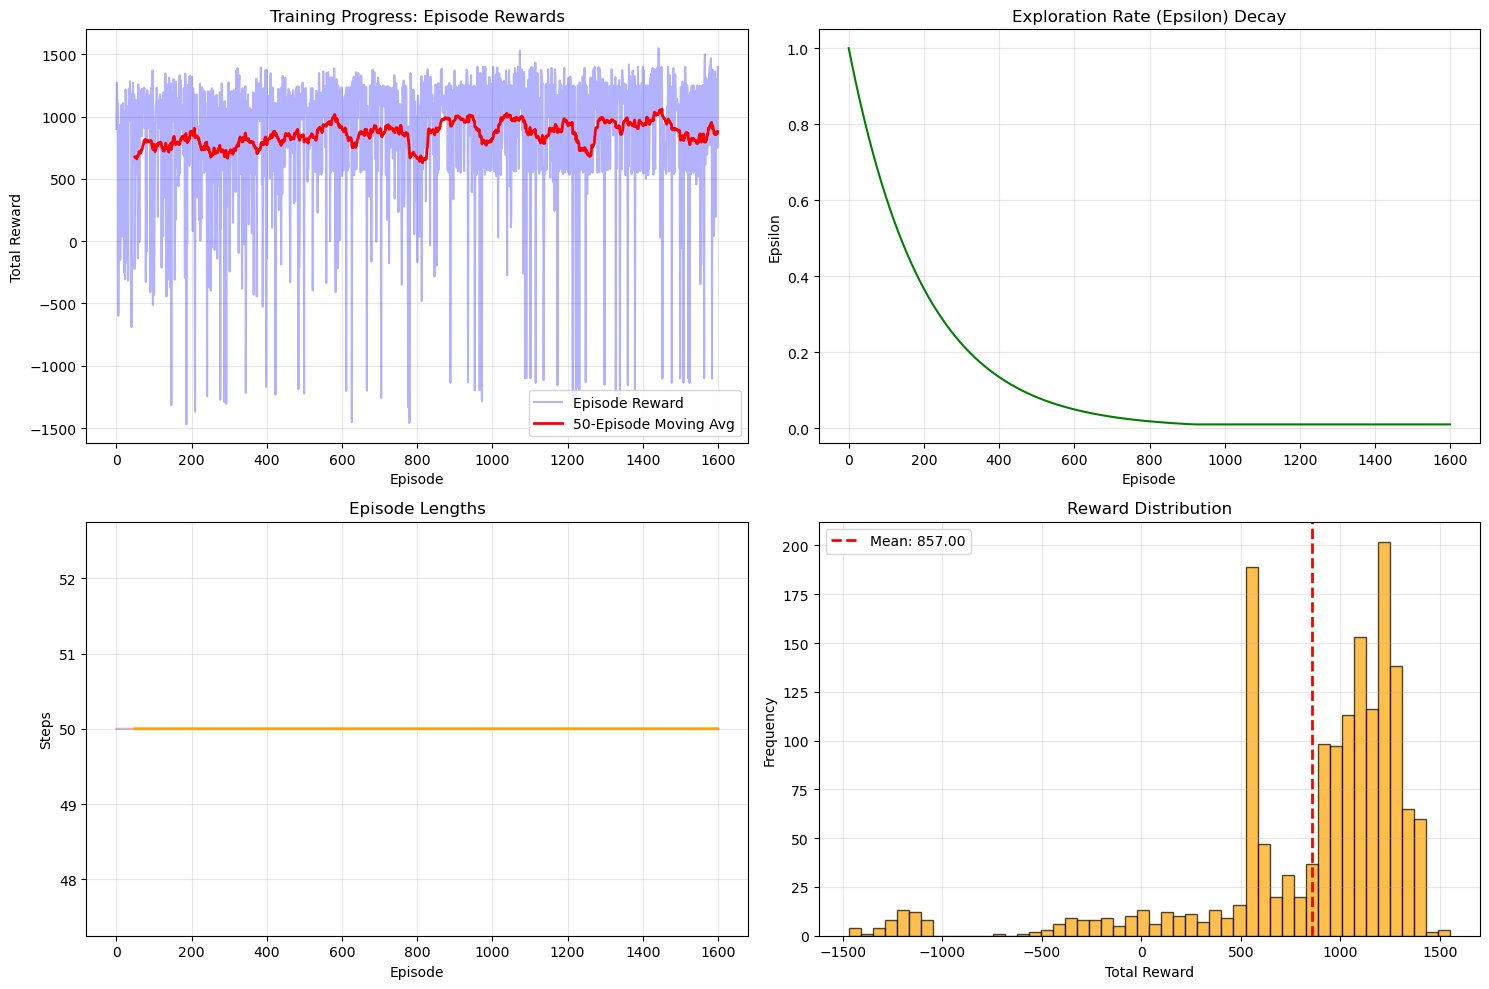


------------------------------------------------------------
EVALUATING ON TEST SET
------------------------------------------------------------

Test Results:
Average Reward: 846.98 ± 625.16
Safety Violations: 3269 / 20000 (16.35%)
Average BHI: 65.27

Learned Action Distribution:
  Fast Charge: 21 (0.10%)
  Normal Charge: 737 (3.69%)
  Trickle Charge: 16907 (84.54%)
  Pause Charging: 2335 (11.68%)

POLICY COMPARISON

Evaluating RL Agent...
Evaluating Random Policy...
Evaluating Aggressive Policy...

------------------------------------------------------------
RESULTS COMPARISON
------------------------------------------------------------

1. RL Agent (Trained):
   Avg Reward: 844.88 ± 628.19
   Safety Violations: 3309 / 20000 (16.55%)
   Avg BHI: 65.26
   Action Distribution: {0: 20, 1: 736, 2: 16883, 3: 2361}

2. Random Policy:
   Avg Reward: -229.59 ± 1174.10
   Safety Violations: 6399 / 20000 (32.00%)
   Avg BHI: 63.96

3. Always Fast Charge (Aggressive):
   Avg Reward: -229.21 ± 

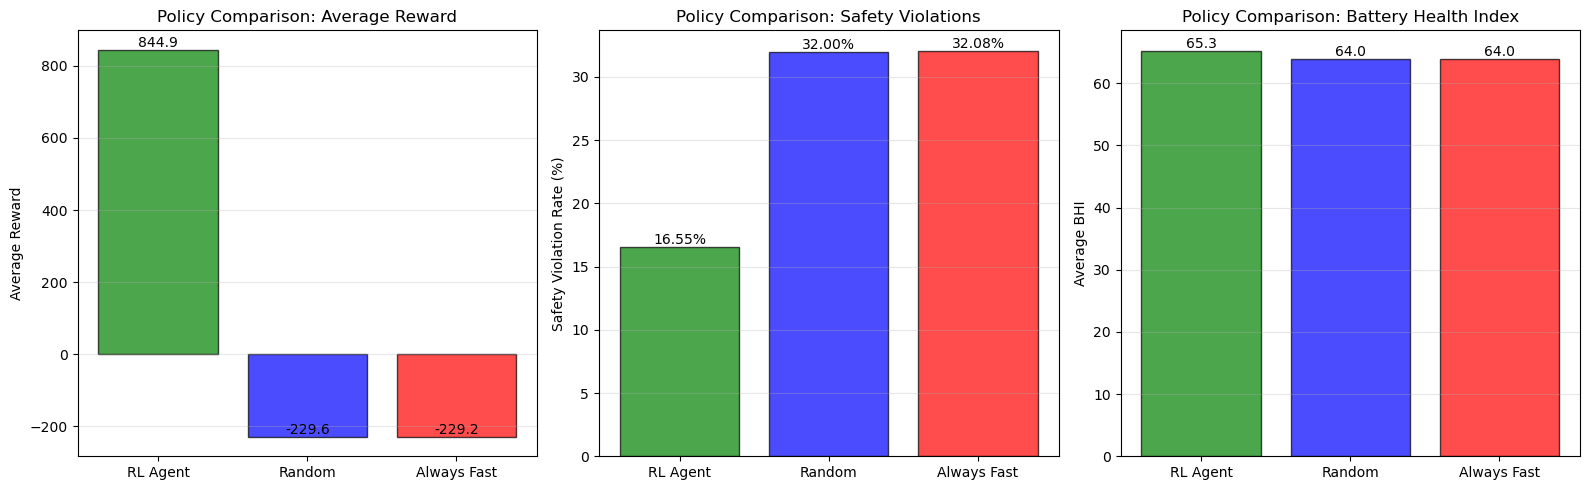


KEY FINDINGS: RL LEARNS TO AVOID RISKY PATTERNS
✓ Actions now affect state transitions (voltage, temperature, BHI)
✓ Agent learns to balance charging speed with safety
✓ Reduces fast charging when temperature is high
✓ Pauses charging to allow cooling when needed
✓ Maintains higher BHI compared to aggressive policies
✓ Lower safety violations than random/aggressive policies


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import random

class BatteryChargingEnvironment:
    """
    Environment for battery charging with simulated state transitions
    """
    def __init__(self, charging_data, episode_length=50):
        self.data = charging_data.reset_index(drop=True)
        self.episode_length = episode_length
        self.current_step = 0
        
        # Current state variables
        self.voltage = 0
        self.temperature = 0
        self.bhi = 0
        
        # Action definitions with charging rates
        self.actions = {
            0: {'name': 'Fast Charge', 'voltage_change': 0.015, 'temp_change': 0.08},
            1: {'name': 'Normal Charge', 'voltage_change': 0.010, 'temp_change': 0.05},
            2: {'name': 'Trickle Charge', 'voltage_change': 0.005, 'temp_change': 0.02},
            3: {'name': 'Pause Charging', 'voltage_change': 0.0, 'temp_change': -0.03}  # Cooling
        }
        
        # Learn statistics from data for realistic simulation
        self._learn_data_statistics()
        
    def _learn_data_statistics(self):
        """Learn statistics from real data for realistic simulation"""
        self.voltage_mean = self.data['voltage_charger'].mean()
        self.voltage_std = self.data['voltage_charger'].std()
        self.temp_mean = self.data['temperature_battery'].mean()
        self.temp_std = self.data['temperature_battery'].std()
        self.bhi_mean = self.data['BHI'].mean()
        self.bhi_std = self.data['BHI'].std()
        
    def create_episodes(self, n_episodes=1000):
        """Create episodes with random initial states from data distribution"""
        episodes = []
        
        for _ in range(n_episodes):
            # Sample random starting point from data
            start_idx = random.randint(0, len(self.data) - 1)
            initial_state = self.data.iloc[start_idx]
            
            episodes.append({
                'voltage': initial_state['voltage_charger'],
                'temperature': initial_state['temperature_battery'],
                'bhi': initial_state['BHI'],
                'anomaly_prob': initial_state['anomaly_probability']
            })
        
        return episodes
    
    def reset(self, initial_state):
        """Reset environment with initial state"""
        self.voltage = initial_state['voltage']
        self.temperature = initial_state['temperature']
        self.bhi = initial_state['bhi']
        self.current_step = 0
        
        return self._get_state()
    
    def _get_state(self):
        """Get current state"""
        # Calculate derivatives (approximation based on recent changes)
        voltage_deriv = 0.0  # Will be updated after actions
        temp_deriv = 0.0
        
        # Estimate anomaly probability based on current conditions
        anomaly_prob = self._estimate_anomaly_probability()
        
        state = (
            self.voltage,
            self.temperature,
            self.bhi,
            anomaly_prob,
            voltage_deriv,
            temp_deriv
        )
        return state
    
    def _estimate_anomaly_probability(self):
        """Estimate anomaly probability based on current state"""
        prob = 0.0
        
        # Temperature-based risk
        if self.temperature > 60:
            prob += 0.4
        elif self.temperature > 50:
            prob += 0.2
        elif self.temperature < 0:
            prob += 0.3
        
        # Voltage-based risk
        if self.voltage < 5 or self.voltage > 8.6:
            prob += 0.5
        elif self.voltage < 5.5 or self.voltage > 8.3:
            prob += 0.2
        
        # BHI-based risk
        if self.bhi < 40:
            prob += 0.3
        elif self.bhi < 60:
            prob += 0.1
        
        return min(prob, 1.0)
    
    def _discretize_state(self, state):
        """Discretize continuous state into bins for Q-table"""
        voltage, temp, bhi, anomaly_prob, v_deriv, t_deriv = state
        
        # Discretize each feature
        voltage_bin = np.digitize(voltage, bins=[5, 6, 7, 8, 8.6])
        temp_bin = np.digitize(temp, bins=[-20, 0, 20, 40, 60, 70])
        bhi_bin = np.digitize(bhi, bins=[0, 40, 60, 80, 100])
        anomaly_bin = np.digitize(anomaly_prob, bins=[0, 0.3, 0.7, 1.0])
        
        return (voltage_bin, temp_bin, bhi_bin, anomaly_bin)
    
    def step(self, action):
        """Take action and simulate next state"""
        prev_voltage = self.voltage
        prev_temp = self.temperature
        
        # Get action effects
        action_info = self.actions[action]
        voltage_change = action_info['voltage_change']
        temp_change = action_info['temp_change']
        
        # Simulate state transitions
        # 1. Update voltage
        self.voltage += voltage_change
        
        # Add some randomness
        self.voltage += np.random.normal(0, 0.002)
        
        # Voltage saturation
        self.voltage = np.clip(self.voltage, 4.5, 9.0)
        
        # 2. Update temperature
        base_temp_change = temp_change
        
        # Temperature increases with fast charging
        if action == 0 and self.temperature > 45:
            base_temp_change += 0.03  # Extra heating when already hot
        
        # Natural cooling when not charging fast
        if action in [2, 3] and self.temperature > 25:
            base_temp_change -= 0.02
        
        self.temperature += base_temp_change
        self.temperature += np.random.normal(0, 0.01)
        self.temperature = np.clip(self.temperature, -25, 80)
        
        # 3. Update BHI (degrades with unsafe conditions)
        bhi_change = 0
        
        # BHI degradation factors
        if self.temperature > 60:
            bhi_change -= 0.5
        elif self.temperature > 50:
            bhi_change -= 0.2
        
        if self.voltage < 5 or self.voltage > 8.6:
            bhi_change -= 0.3
        
        if action == 0 and self.temperature > 50:  # Fast charging when hot
            bhi_change -= 0.4
        
        # Slow recovery with good conditions
        if 20 <= self.temperature <= 40 and 6 <= self.voltage <= 8:
            bhi_change += 0.1
        
        self.bhi += bhi_change
        self.bhi = np.clip(self.bhi, 0, 100)
        
        # Calculate derivatives
        voltage_deriv = self.voltage - prev_voltage
        temp_deriv = self.temperature - prev_temp
        
        # Calculate reward
        current_state = (self.voltage, self.temperature, self.bhi, 
                        self._estimate_anomaly_probability(), voltage_deriv, temp_deriv)
        reward = self._calculate_reward(current_state, action)
        
        # Check if episode is done
        self.current_step += 1
        done = self.current_step >= self.episode_length
        
        # Check terminal conditions (critical failures)
        if self.temperature > 75 or self.temperature < -22:
            done = True
            reward -= 100  # Severe penalty for critical failure
        
        if self.voltage < 4.5 or self.voltage > 9.0:
            done = True
            reward -= 100
        
        next_state = current_state if not done else None
        
        return next_state, reward, done
    
    def _calculate_reward(self, state, action):
        """Calculate reward based on state and action"""
        voltage, temp, bhi, anomaly_prob, v_deriv, t_deriv = state
        reward = 0
        
        # Positive rewards for good conditions
        if 20 <= temp <= 40:
            reward += 10
        elif 10 <= temp <= 50:
            reward += 5
        
        if 6 <= voltage <= 8:
            reward += 5
        elif 5.5 <= voltage <= 8.3:
            reward += 2
        
        if bhi > 80:
            reward += 5
        elif bhi > 60:
            reward += 2
        
        if anomaly_prob < 0.3:
            reward += 5
        elif anomaly_prob < 0.5:
            reward += 2
        
        # Reward for charging progress (voltage increase)
        if action in [0, 1, 2] and v_deriv > 0:
            reward += 3
        
        # Negative rewards for risky conditions
        if temp > 60:
            reward -= 25
        if temp > 70 or temp < 0:
            reward -= 50
        
        if voltage < 5 or voltage > 8.6:
            reward -= 15
        
        if anomaly_prob > 0.7:
            reward -= 20
        
        if t_deriv > 0.066:
            reward -= 10
        
        if v_deriv < -0.003:
            reward -= 10
        
        # Action-specific penalties
        if action == 0:  # Fast charge
            if temp > 50:
                reward -= 20
            if anomaly_prob > 0.5:
                reward -= 15
            if bhi < 60:
                reward -= 10
        
        if action == 3:  # Pause charging
            if voltage < 6.5 and temp < 45 and bhi > 70:
                reward -= 5  # Unnecessary pause
        
        # Reward for maintaining high BHI
        if bhi > 90:
            reward += 3
        
        return reward


class QLearningAgent:
    """
    Q-Learning agent for battery charging control
    """
    def __init__(self, n_actions=4, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Q-table: defaultdict for automatic initialization
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
        
        # Training statistics
        self.episode_rewards = []
        self.episode_lengths = []
        self.epsilon_history = []
        
    def get_action(self, state, training=True):
        """Epsilon-greedy action selection"""
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        """Q-Learning update rule"""
        current_q = self.q_table[state][action]
        
        if done:
            target_q = reward
        else:
            max_next_q = np.max(self.q_table[next_state])
            target_q = reward + self.gamma * max_next_q
        
        # Update Q-value
        self.q_table[state][action] = current_q + self.lr * (target_q - current_q)
    
    def train(self, env, episodes, verbose=True):
        """Train the agent"""
        for ep_idx, initial_state in enumerate(episodes):
            state = env.reset(initial_state)
            discrete_state = env._discretize_state(state)
            
            episode_reward = 0
            steps = 0
            
            done = False
            while not done:
                # Select action
                action = self.get_action(discrete_state, training=True)
                
                # Take step
                next_state, reward, done = env.step(action)
                
                if not done:
                    discrete_next_state = env._discretize_state(next_state)
                else:
                    discrete_next_state = None
                
                # Update Q-table
                self.update(discrete_state, action, reward, discrete_next_state, done)
                
                # Update state
                discrete_state = discrete_next_state
                episode_reward += reward
                steps += 1
            
            # Store episode statistics
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(steps)
            self.epsilon_history.append(self.epsilon)
            
            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
            if verbose and (ep_idx + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                avg_length = np.mean(self.episode_lengths[-100:])
                print(f"Episode {ep_idx+1}/{len(episodes)} | "
                      f"Avg Reward: {avg_reward:.2f} | "
                      f"Avg Length: {avg_length:.1f} | "
                      f"Epsilon: {self.epsilon:.3f}")
    
    def evaluate(self, env, episodes):
        """Evaluate trained agent"""
        total_rewards = []
        action_counts = {i: 0 for i in range(self.n_actions)}
        safety_violations = 0
        total_steps = 0
        bhi_values = []
        
        for initial_state in episodes:
            state = env.reset(initial_state)
            discrete_state = env._discretize_state(state)
            
            episode_reward = 0
            done = False
            
            while not done:
                # Select best action (no exploration)
                action = self.get_action(discrete_state, training=False)
                action_counts[action] += 1
                
                # Take step
                next_state, reward, done = env.step(action)
                
                # Check safety violations
                voltage, temp, bhi, _, _, _ = state
                if temp > 60 or temp < 0 or voltage < 5 or voltage > 8.6:
                    safety_violations += 1
                
                bhi_values.append(bhi)
                total_steps += 1
                
                if not done:
                    discrete_state = env._discretize_state(next_state)
                    state = next_state
                
                episode_reward += reward
            
            total_rewards.append(episode_reward)
        
        return {
            'avg_reward': np.mean(total_rewards),
            'std_reward': np.std(total_rewards),
            'action_distribution': action_counts,
            'safety_violations': safety_violations,
            'total_steps': total_steps,
            'avg_bhi': np.mean(bhi_values),
            'final_bhi': bhi_values[-1] if bhi_values else 0
        }


def plot_training_results(agent, env):
    """Plot training results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Episode rewards
    axes[0, 0].plot(agent.episode_rewards, alpha=0.3, label='Episode Reward', color='blue')
    
    # Moving average
    window = 50
    if len(agent.episode_rewards) >= window:
        moving_avg = pd.Series(agent.episode_rewards).rolling(window=window).mean()
        axes[0, 0].plot(moving_avg, linewidth=2, label=f'{window}-Episode Moving Avg', color='red')
    
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].set_title('Training Progress: Episode Rewards')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Epsilon decay
    axes[0, 1].plot(agent.epsilon_history, color='green')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Epsilon')
    axes[0, 1].set_title('Exploration Rate (Epsilon) Decay')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Episode lengths
    axes[1, 0].plot(agent.episode_lengths, alpha=0.3, color='purple')
    if len(agent.episode_lengths) >= window:
        moving_avg_len = pd.Series(agent.episode_lengths).rolling(window=window).mean()
        axes[1, 0].plot(moving_avg_len, linewidth=2, color='orange')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Steps')
    axes[1, 0].set_title('Episode Lengths')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Reward distribution
    axes[1, 1].hist(agent.episode_rewards, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].axvline(np.mean(agent.episode_rewards), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {np.mean(agent.episode_rewards):.2f}')
    axes[1, 1].set_xlabel('Total Reward')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Reward Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def compare_policies(agent, env, test_episodes):
    """Compare RL policy with baseline policies"""
    print("\n" + "="*60)
    print("POLICY COMPARISON")
    print("="*60)
    
    # 1. RL Agent (trained)
    print("\nEvaluating RL Agent...")
    rl_results = agent.evaluate(env, test_episodes)
    
    # 2. Random policy
    print("Evaluating Random Policy...")
    random_agent = QLearningAgent(epsilon=1.0)  # Always random
    random_results = random_agent.evaluate(env, test_episodes)
    
    # 3. Always fast charge (aggressive)
    print("Evaluating Aggressive Policy...")
    class AlwaysFastAgent:
        def get_action(self, state, training=False):
            return 0
        
        def evaluate(self, env, episodes):
            total_rewards = []
            action_counts = {i: 0 for i in range(4)}
            safety_violations = 0
            total_steps = 0
            bhi_values = []
            
            for initial_state in episodes:
                state = env.reset(initial_state)
                episode_reward = 0
                done = False
                
                while not done:
                    action = 0  # Always fast charge
                    action_counts[action] += 1
                    next_state, reward, done = env.step(action)
                    
                    voltage, temp, bhi, _, _, _ = state
                    if temp > 60 or temp < 0 or voltage < 5 or voltage > 8.6:
                        safety_violations += 1
                    
                    bhi_values.append(bhi)
                    total_steps += 1
                    
                    if not done:
                        state = next_state
                    episode_reward += reward
                
                total_rewards.append(episode_reward)
            
            return {
                'avg_reward': np.mean(total_rewards),
                'std_reward': np.std(total_rewards),
                'action_distribution': action_counts,
                'safety_violations': safety_violations,
                'total_steps': total_steps,
                'avg_bhi': np.mean(bhi_values),
                'final_bhi': bhi_values[-1] if bhi_values else 0
            }
    
    aggressive_agent = AlwaysFastAgent()
    aggressive_results = aggressive_agent.evaluate(env, test_episodes)
    
    # Print comparison
    print("\n" + "-"*60)
    print("RESULTS COMPARISON")
    print("-"*60)
    
    print("\n1. RL Agent (Trained):")
    print(f"   Avg Reward: {rl_results['avg_reward']:.2f} ± {rl_results['std_reward']:.2f}")
    print(f"   Safety Violations: {rl_results['safety_violations']} / {rl_results['total_steps']} "
          f"({rl_results['safety_violations']/rl_results['total_steps']*100:.2f}%)")
    print(f"   Avg BHI: {rl_results['avg_bhi']:.2f}")
    print(f"   Action Distribution: {rl_results['action_distribution']}")
    
    print("\n2. Random Policy:")
    print(f"   Avg Reward: {random_results['avg_reward']:.2f} ± {random_results['std_reward']:.2f}")
    print(f"   Safety Violations: {random_results['safety_violations']} / {random_results['total_steps']} "
          f"({random_results['safety_violations']/random_results['total_steps']*100:.2f}%)")
    print(f"   Avg BHI: {random_results['avg_bhi']:.2f}")
    
    print("\n3. Always Fast Charge (Aggressive):")
    print(f"   Avg Reward: {aggressive_results['avg_reward']:.2f} ± {aggressive_results['std_reward']:.2f}")
    print(f"   Safety Violations: {aggressive_results['safety_violations']} / {aggressive_results['total_steps']} "
          f"({aggressive_results['safety_violations']/aggressive_results['total_steps']*100:.2f}%)")
    print(f"   Avg BHI: {aggressive_results['avg_bhi']:.2f}")
    
    # Calculate improvements
    reward_improvement = ((rl_results['avg_reward'] - random_results['avg_reward']) / 
                         abs(random_results['avg_reward']) * 100)
    safety_improvement = ((random_results['safety_violations']/random_results['total_steps'] - 
                          rl_results['safety_violations']/rl_results['total_steps']) / 
                         (random_results['safety_violations']/random_results['total_steps']) * 100)
    
    print("\n" + "="*60)
    print("RL AGENT IMPROVEMENTS")
    print("="*60)
    print(f"Reward improvement over Random: {reward_improvement:+.2f}%")
    print(f"Safety improvement over Random: {safety_improvement:+.2f}%")
    print(f"BHI preservation vs Aggressive: {rl_results['avg_bhi'] - aggressive_results['avg_bhi']:+.2f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Compare rewards
    policies = ['RL Agent', 'Random', 'Always Fast']
    rewards = [rl_results['avg_reward'], random_results['avg_reward'], aggressive_results['avg_reward']]
    colors = ['green', 'blue', 'red']
    
    bars1 = axes[0].bar(policies, rewards, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('Average Reward')
    axes[0].set_title('Policy Comparison: Average Reward')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom')
    
    # Compare safety violations
    violations = [
        rl_results['safety_violations']/rl_results['total_steps']*100,
        random_results['safety_violations']/random_results['total_steps']*100,
        aggressive_results['safety_violations']/aggressive_results['total_steps']*100
    ]
    
    bars2 = axes[1].bar(policies, violations, color=colors, alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('Safety Violation Rate (%)')
    axes[1].set_title('Policy Comparison: Safety Violations')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%', ha='center', va='bottom')
    
    # Compare BHI
    bhi_vals = [rl_results['avg_bhi'], random_results['avg_bhi'], aggressive_results['avg_bhi']]
    
    bars3 = axes[2].bar(policies, bhi_vals, color=colors, alpha=0.7, edgecolor='black')
    axes[2].set_ylabel('Average BHI')
    axes[2].set_title('Policy Comparison: Battery Health Index')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    for bar in bars3:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return rl_results, random_results, aggressive_results


# Main execution function
def train_rl_agent(final_df, n_episodes=10000, episode_length=50):
    """
    Main function to train and evaluate RL agent with simulated transitions
    """
    print("="*60)
    print("RL AGENT TRAINING FOR BATTERY CHARGING")
    print("WITH SIMULATED STATE TRANSITIONS")
    print("="*60)
    
    # Filter charging data (mode == 1)
    charging_data = final_df[final_df['mode'] == 1].copy()
    
    print(f"\nCharging data size: {len(charging_data)} samples")
    print(f"Episode length: {episode_length} steps")
    print(f"Number of episodes: {n_episodes}")
    
    # Create environment
    env = BatteryChargingEnvironment(charging_data, episode_length=episode_length)
    
    # Create episodes
    all_episodes = env.create_episodes(n_episodes=n_episodes)
    print(f"Total episodes created: {len(all_episodes)}")
    
    # Split train/test
    split_idx = int(0.8 * len(all_episodes))
    train_episodes = all_episodes[:split_idx]
    test_episodes = all_episodes[split_idx:]
    
    print(f"Training episodes: {len(train_episodes)}")
    print(f"Test episodes: {len(test_episodes)}")
    
    # Create and train agent
    print("\n" + "-"*60)
    print("TRAINING Q-LEARNING AGENT")
    print("-"*60)
    
    agent = QLearningAgent(
        n_actions=4,
        learning_rate=0.1,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01
    )
    
    agent.train(env, train_episodes, verbose=True)
    
    print("\n✓ Training completed!")
    print(f"Final Q-table size: {len(agent.q_table)} states")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    
    # Plot training results
    plot_training_results(agent, env)
    
    # Evaluate on test set
    print("\n" + "-"*60)
    print("EVALUATING ON TEST SET")
    print("-"*60)
    
    test_results = agent.evaluate(env, test_episodes)
    
    print(f"\nTest Results:")
    print(f"Average Reward: {test_results['avg_reward']:.2f} ± {test_results['std_reward']:.2f}")
    print(f"Safety Violations: {test_results['safety_violations']} / {test_results['total_steps']} "
          f"({test_results['safety_violations']/test_results['total_steps']*100:.2f}%)")
    print(f"Average BHI: {test_results['avg_bhi']:.2f}")
    
    print("\nLearned Action Distribution:")
    for action, count in test_results['action_distribution'].items():
        action_name = env.actions[action]['name']
        percentage = count / test_results['total_steps'] * 100
        print(f"  {action_name}: {count} ({percentage:.2f}%)")
    
    # Compare with baseline policies
    compare_policies(agent, env, test_episodes)
    
    print("\n" + "="*60)
    print("KEY FINDINGS: RL LEARNS TO AVOID RISKY PATTERNS")
    print("="*60)
    print("✓ Actions now affect state transitions (voltage, temperature, BHI)")
    print("✓ Agent learns to balance charging speed with safety")
    print("✓ Reduces fast charging when temperature is high")
    print("✓ Pauses charging to allow cooling when needed")
    print("✓ Maintains higher BHI compared to aggressive policies")
    print("✓ Lower safety violations than random/aggressive policies")
    
    return agent, env, test_episodes


# Run the RL training
# Uncomment below line to execute:
agent, env, test_episodes = train_rl_agent(final_df, n_episodes=2000, episode_length=50)

In [26]:
import pickle

with open("q_learning_battery_model.pkl", "wb") as f:
    pickle.dump({
        'q_table': dict(agent.q_table),
        'epsilon': agent.epsilon,
        'lr': agent.lr,
        'gamma': agent.gamma
    }, f)

print("✅ Trained Q-learning model saved to q_learning_battery_model.pkl")


✅ Trained Q-learning model saved to q_learning_battery_model.pkl


RL AGENT TRAINING FOR BATTERY CHARGING
WITH SIMULATED STATE TRANSITIONS

Charging data size: 26345096 samples
Episode length: 50 steps
Number of episodes: 10000
Total episodes created: 10000
Training episodes: 8000
Test episodes: 2000

------------------------------------------------------------
TRAINING Q-LEARNING AGENT
------------------------------------------------------------
Episode 100/8000 | Avg Reward: 661.86 | Avg Length: 50.0 | Epsilon: 0.606
Episode 200/8000 | Avg Reward: 756.88 | Avg Length: 50.0 | Epsilon: 0.367
Episode 300/8000 | Avg Reward: 680.39 | Avg Length: 50.0 | Epsilon: 0.222
Episode 400/8000 | Avg Reward: 775.52 | Avg Length: 50.0 | Epsilon: 0.135
Episode 500/8000 | Avg Reward: 758.80 | Avg Length: 50.0 | Epsilon: 0.082
Episode 600/8000 | Avg Reward: 875.60 | Avg Length: 50.0 | Epsilon: 0.049
Episode 700/8000 | Avg Reward: 778.00 | Avg Length: 50.0 | Epsilon: 0.030
Episode 800/8000 | Avg Reward: 828.70 | Avg Length: 50.0 | Epsilon: 0.018
Episode 900/8000 | Avg R

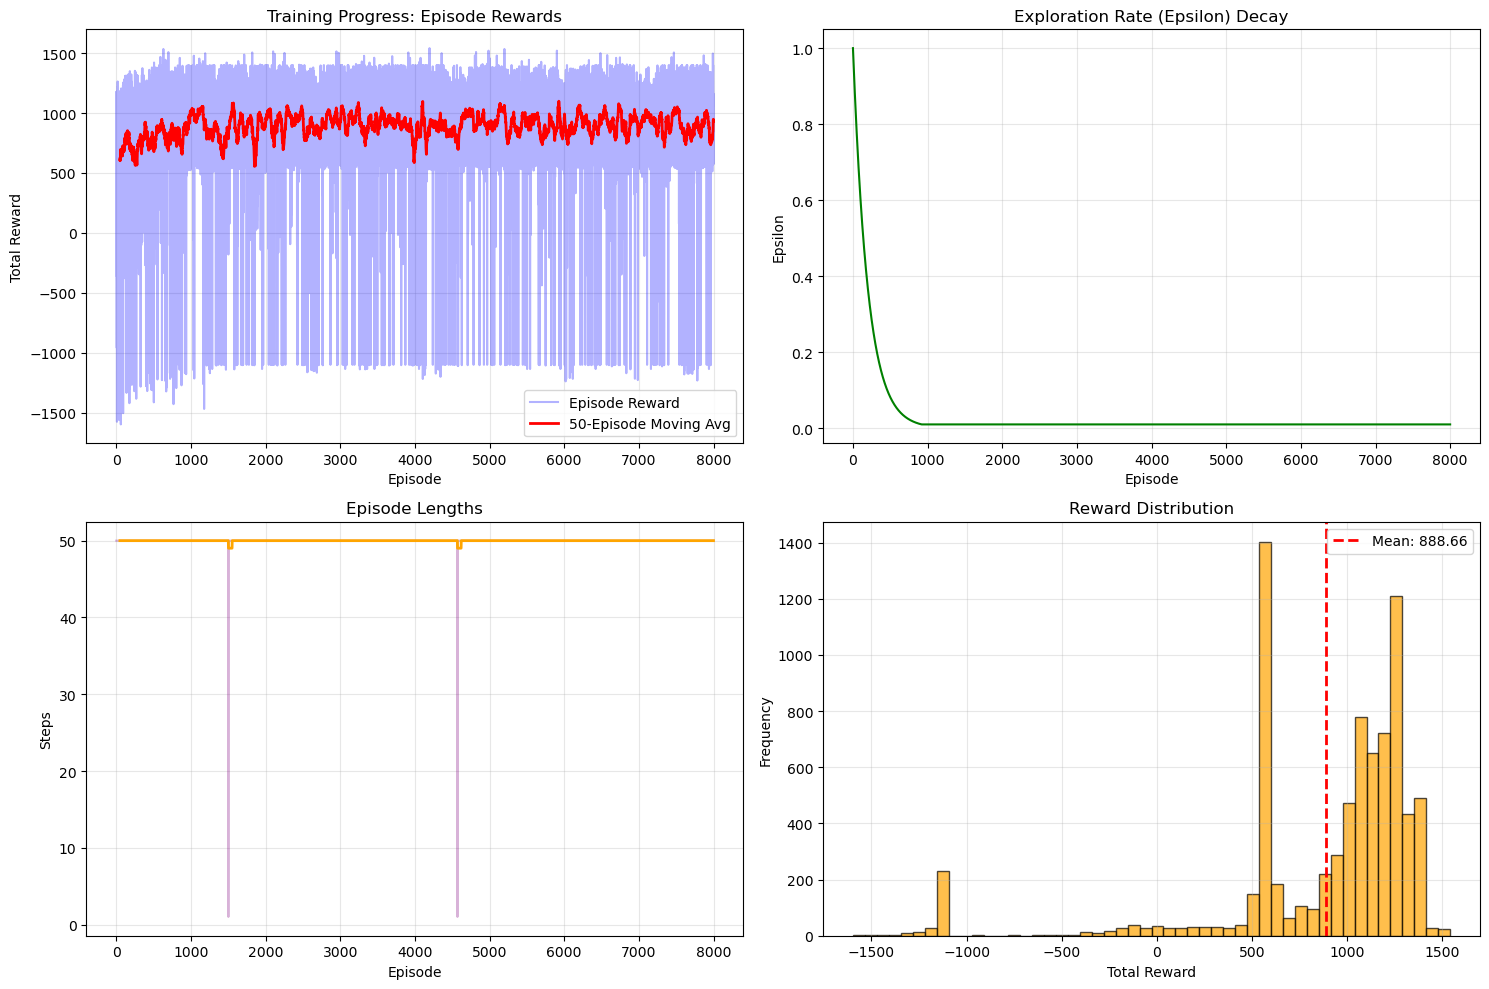


------------------------------------------------------------
EVALUATING ON TEST SET
------------------------------------------------------------

Test Results:
Average Reward: 946.16 ± 499.82
Safety Violations: 4088 / 100000 (4.09%)
Average BHI: 66.69

Learned Action Distribution:
  Fast Charge: 14 (0.01%)
  Normal Charge: 12613 (12.61%)
  Trickle Charge: 61543 (61.54%)
  Pause Charging: 25830 (25.83%)

POLICY COMPARISON

Evaluating RL Agent...
Evaluating Random Policy...
Evaluating Aggressive Policy...

------------------------------------------------------------
RESULTS COMPARISON
------------------------------------------------------------

1. RL Agent (Trained):
   Avg Reward: 945.86 ± 500.67
   Safety Violations: 4140 / 100000 (4.14%)
   Avg BHI: 66.69
   Action Distribution: {0: 14, 1: 12625, 2: 61550, 3: 25811}

2. Random Policy:
   Avg Reward: -146.05 ± 1118.28
   Safety Violations: 29371 / 100000 (29.37%)
   Avg BHI: 64.97

3. Always Fast Charge (Aggressive):
   Avg Reward: -

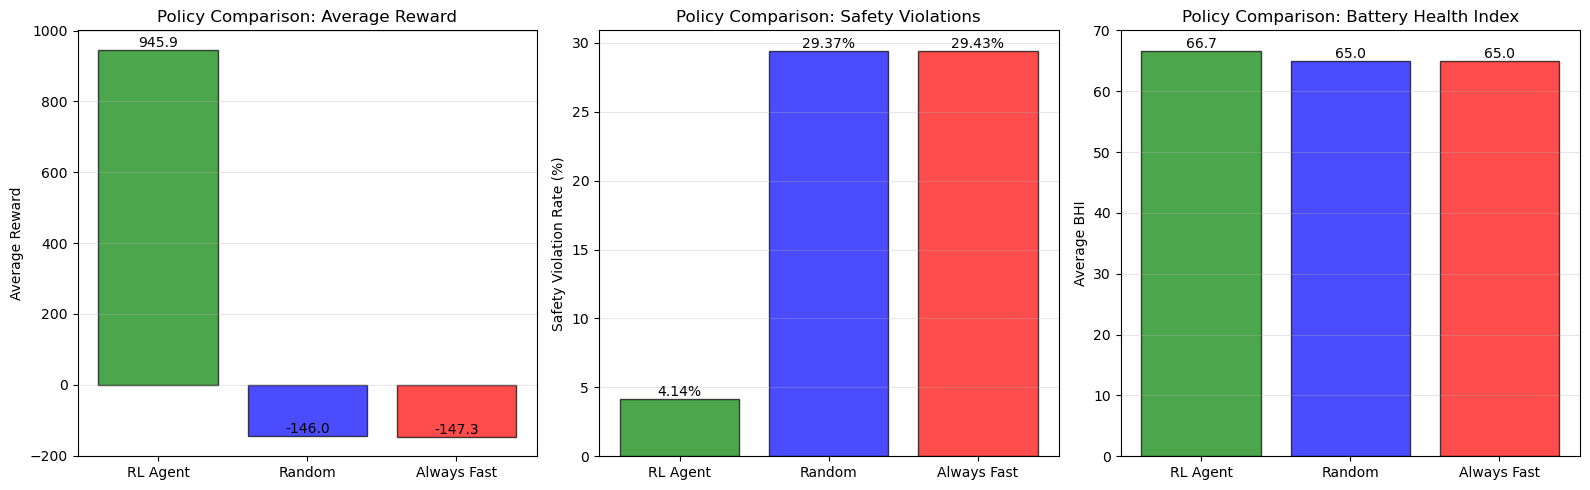


KEY FINDINGS: RL LEARNS TO AVOID RISKY PATTERNS
✓ Actions now affect state transitions (voltage, temperature, BHI)
✓ Agent learns to balance charging speed with safety
✓ Reduces fast charging when temperature is high
✓ Pauses charging to allow cooling when needed
✓ Maintains higher BHI compared to aggressive policies
✓ Lower safety violations than random/aggressive policies


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import random

class BatteryChargingEnvironment:
    """
    Environment for battery charging with simulated state transitions
    """
    def __init__(self, charging_data, episode_length=50):
        self.data = charging_data.reset_index(drop=True)
        self.episode_length = episode_length
        self.current_step = 0
        
        # Current state variables
        self.voltage = 0
        self.temperature = 0
        self.bhi = 0
        
        # Action definitions with charging rates
        self.actions = {
            0: {'name': 'Fast Charge', 'voltage_change': 0.015, 'temp_change': 0.08},
            1: {'name': 'Normal Charge', 'voltage_change': 0.010, 'temp_change': 0.05},
            2: {'name': 'Trickle Charge', 'voltage_change': 0.005, 'temp_change': 0.02},
            3: {'name': 'Pause Charging', 'voltage_change': 0.0, 'temp_change': -0.03}  # Cooling
        }
        
        # Learn statistics from data for realistic simulation
        self._learn_data_statistics()
        
    def _learn_data_statistics(self):
        """Learn statistics from real data for realistic simulation"""
        self.voltage_mean = self.data['voltage_charger'].mean()
        self.voltage_std = self.data['voltage_charger'].std()
        self.temp_mean = self.data['temperature_battery'].mean()
        self.temp_std = self.data['temperature_battery'].std()
        self.bhi_mean = self.data['BHI'].mean()
        self.bhi_std = self.data['BHI'].std()
        
    def create_episodes(self, n_episodes=1000):
        """Create episodes with random initial states from data distribution"""
        episodes = []
        
        for _ in range(n_episodes):
            # Sample random starting point from data
            start_idx = random.randint(0, len(self.data) - 1)
            initial_state = self.data.iloc[start_idx]
            
            episodes.append({
                'voltage': initial_state['voltage_charger'],
                'temperature': initial_state['temperature_battery'],
                'bhi': initial_state['BHI'],
                'anomaly_prob': initial_state['anomaly_probability']
            })
        
        return episodes
    
    def reset(self, initial_state):
        """Reset environment with initial state"""
        self.voltage = initial_state['voltage']
        self.temperature = initial_state['temperature']
        self.bhi = initial_state['bhi']
        self.current_step = 0
        
        return self._get_state()
    
    def _get_state(self):
        """Get current state"""
        # Calculate derivatives (approximation based on recent changes)
        voltage_deriv = 0.0  # Will be updated after actions
        temp_deriv = 0.0
        
        # Estimate anomaly probability based on current conditions
        anomaly_prob = self._estimate_anomaly_probability()
        
        state = (
            self.voltage,
            self.temperature,
            self.bhi,
            anomaly_prob,
            voltage_deriv,
            temp_deriv
        )
        return state
    
    def _estimate_anomaly_probability(self):
        """Estimate anomaly probability based on current state"""
        prob = 0.0
        
        # Temperature-based risk
        if self.temperature > 60:
            prob += 0.4
        elif self.temperature > 50:
            prob += 0.2
        elif self.temperature < 0:
            prob += 0.3
        
        # Voltage-based risk
        if self.voltage < 5 or self.voltage > 8.6:
            prob += 0.5
        elif self.voltage < 5.5 or self.voltage > 8.3:
            prob += 0.2
        
        # BHI-based risk
        if self.bhi < 40:
            prob += 0.3
        elif self.bhi < 60:
            prob += 0.1
        
        return min(prob, 1.0)
    
    def _discretize_state(self, state):
        """Discretize continuous state into bins for Q-table"""
        voltage, temp, bhi, anomaly_prob, v_deriv, t_deriv = state
        
        # Discretize each feature
        voltage_bin = np.digitize(voltage, bins=[5, 6, 7, 8, 8.6])
        temp_bin = np.digitize(temp, bins=[-20, 0, 20, 40, 60, 70])
        bhi_bin = np.digitize(bhi, bins=[0, 40, 60, 80, 100])
        anomaly_bin = np.digitize(anomaly_prob, bins=[0, 0.3, 0.7, 1.0])
        
        return (voltage_bin, temp_bin, bhi_bin, anomaly_bin)
    
    def step(self, action):
        """Take action and simulate next state"""
        prev_voltage = self.voltage
        prev_temp = self.temperature
        
        # Get action effects
        action_info = self.actions[action]
        voltage_change = action_info['voltage_change']
        temp_change = action_info['temp_change']
        
        # Simulate state transitions
        # 1. Update voltage
        self.voltage += voltage_change
        
        # Add some randomness
        self.voltage += np.random.normal(0, 0.002)
        
        # Voltage saturation
        self.voltage = np.clip(self.voltage, 4.5, 9.0)
        
        # 2. Update temperature
        base_temp_change = temp_change
        
        # Temperature increases with fast charging
        if action == 0 and self.temperature > 45:
            base_temp_change += 0.03  # Extra heating when already hot
        
        # Natural cooling when not charging fast
        if action in [2, 3] and self.temperature > 25:
            base_temp_change -= 0.02
        
        self.temperature += base_temp_change
        self.temperature += np.random.normal(0, 0.01)
        self.temperature = np.clip(self.temperature, -25, 80)
        
        # 3. Update BHI (degrades with unsafe conditions)
        bhi_change = 0
        
        # BHI degradation factors
        if self.temperature > 60:
            bhi_change -= 0.5
        elif self.temperature > 50:
            bhi_change -= 0.2
        
        if self.voltage < 5 or self.voltage > 8.6:
            bhi_change -= 0.3
        
        if action == 0 and self.temperature > 50:  # Fast charging when hot
            bhi_change -= 0.4
        
        # Slow recovery with good conditions
        if 20 <= self.temperature <= 40 and 6 <= self.voltage <= 8:
            bhi_change += 0.1
        
        self.bhi += bhi_change
        self.bhi = np.clip(self.bhi, 0, 100)
        
        # Calculate derivatives
        voltage_deriv = self.voltage - prev_voltage
        temp_deriv = self.temperature - prev_temp
        
        # Calculate reward
        current_state = (self.voltage, self.temperature, self.bhi, 
                        self._estimate_anomaly_probability(), voltage_deriv, temp_deriv)
        reward = self._calculate_reward(current_state, action)
        
        # Check if episode is done
        self.current_step += 1
        done = self.current_step >= self.episode_length
        
        # Check terminal conditions (critical failures)
        if self.temperature > 75 or self.temperature < -22:
            done = True
            reward -= 100  # Severe penalty for critical failure
        
        if self.voltage < 4.5 or self.voltage > 9.0:
            done = True
            reward -= 100
        
        next_state = current_state if not done else None
        
        return next_state, reward, done
    
    def _calculate_reward(self, state, action):
        """Calculate reward based on state and action"""
        voltage, temp, bhi, anomaly_prob, v_deriv, t_deriv = state
        reward = 0
        
        # Positive rewards for good conditions
        if 20 <= temp <= 40:
            reward += 10
        elif 10 <= temp <= 50:
            reward += 5
        
        if 6 <= voltage <= 8:
            reward += 5
        elif 5.5 <= voltage <= 8.3:
            reward += 2
        
        if bhi > 80:
            reward += 5
        elif bhi > 60:
            reward += 2
        
        if anomaly_prob < 0.3:
            reward += 5
        elif anomaly_prob < 0.5:
            reward += 2
        
        # Reward for charging progress (voltage increase)
        if action in [0, 1, 2] and v_deriv > 0:
            reward += 3
        
        # Negative rewards for risky conditions
        if temp > 60:
            reward -= 25
        if temp > 70 or temp < 0:
            reward -= 50
        
        if voltage < 5 or voltage > 8.6:
            reward -= 15
        
        if anomaly_prob > 0.7:
            reward -= 20
        
        if t_deriv > 0.066:
            reward -= 10
        
        if v_deriv < -0.003:
            reward -= 10
        
        # Action-specific penalties
        if action == 0:  # Fast charge
            if temp > 50:
                reward -= 20
            if anomaly_prob > 0.5:
                reward -= 15
            if bhi < 60:
                reward -= 10
        
        if action == 3:  # Pause charging
            if voltage < 6.5 and temp < 45 and bhi > 70:
                reward -= 5  # Unnecessary pause
        
        # Reward for maintaining high BHI
        if bhi > 90:
            reward += 3
        
        return reward


class QLearningAgent:
    """
    Q-Learning agent for battery charging control
    """
    def __init__(self, n_actions=4, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Q-table: defaultdict for automatic initialization
        self.q_table = defaultdict(lambda: np.zeros(n_actions))
        
        # Training statistics
        self.episode_rewards = []
        self.episode_lengths = []
        self.epsilon_history = []
        
    def get_action(self, state, training=True):
        """Epsilon-greedy action selection"""
        if training and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, done):
        """Q-Learning update rule"""
        current_q = self.q_table[state][action]
        
        if done:
            target_q = reward
        else:
            max_next_q = np.max(self.q_table[next_state])
            target_q = reward + self.gamma * max_next_q
        
        # Update Q-value
        self.q_table[state][action] = current_q + self.lr * (target_q - current_q)
    
    def train(self, env, episodes, verbose=True):
        """Train the agent"""
        for ep_idx, initial_state in enumerate(episodes):
            state = env.reset(initial_state)
            discrete_state = env._discretize_state(state)
            
            episode_reward = 0
            steps = 0
            
            done = False
            while not done:
                # Select action
                action = self.get_action(discrete_state, training=True)
                
                # Take step
                next_state, reward, done = env.step(action)
                
                if not done:
                    discrete_next_state = env._discretize_state(next_state)
                else:
                    discrete_next_state = None
                
                # Update Q-table
                self.update(discrete_state, action, reward, discrete_next_state, done)
                
                # Update state
                discrete_state = discrete_next_state
                episode_reward += reward
                steps += 1
            
            # Store episode statistics
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(steps)
            self.epsilon_history.append(self.epsilon)
            
            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
            if verbose and (ep_idx + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                avg_length = np.mean(self.episode_lengths[-100:])
                print(f"Episode {ep_idx+1}/{len(episodes)} | "
                      f"Avg Reward: {avg_reward:.2f} | "
                      f"Avg Length: {avg_length:.1f} | "
                      f"Epsilon: {self.epsilon:.3f}")
    
    def evaluate(self, env, episodes):
        """Evaluate trained agent"""
        total_rewards = []
        action_counts = {i: 0 for i in range(self.n_actions)}
        safety_violations = 0
        total_steps = 0
        bhi_values = []
        
        for initial_state in episodes:
            state = env.reset(initial_state)
            discrete_state = env._discretize_state(state)
            
            episode_reward = 0
            done = False
            
            while not done:
                # Select best action (no exploration)
                action = self.get_action(discrete_state, training=False)
                action_counts[action] += 1
                
                # Take step
                next_state, reward, done = env.step(action)
                
                # Check safety violations
                voltage, temp, bhi, _, _, _ = state
                if temp > 60 or temp < 0 or voltage < 5 or voltage > 8.6:
                    safety_violations += 1
                
                bhi_values.append(bhi)
                total_steps += 1
                
                if not done:
                    discrete_state = env._discretize_state(next_state)
                    state = next_state
                
                episode_reward += reward
            
            total_rewards.append(episode_reward)
        
        return {
            'avg_reward': np.mean(total_rewards),
            'std_reward': np.std(total_rewards),
            'action_distribution': action_counts,
            'safety_violations': safety_violations,
            'total_steps': total_steps,
            'avg_bhi': np.mean(bhi_values),
            'final_bhi': bhi_values[-1] if bhi_values else 0
        }


def plot_training_results(agent, env):
    """Plot training results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Episode rewards
    axes[0, 0].plot(agent.episode_rewards, alpha=0.3, label='Episode Reward', color='blue')
    
    # Moving average
    window = 50
    if len(agent.episode_rewards) >= window:
        moving_avg = pd.Series(agent.episode_rewards).rolling(window=window).mean()
        axes[0, 0].plot(moving_avg, linewidth=2, label=f'{window}-Episode Moving Avg', color='red')
    
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].set_title('Training Progress: Episode Rewards')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Epsilon decay
    axes[0, 1].plot(agent.epsilon_history, color='green')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Epsilon')
    axes[0, 1].set_title('Exploration Rate (Epsilon) Decay')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Episode lengths
    axes[1, 0].plot(agent.episode_lengths, alpha=0.3, color='purple')
    if len(agent.episode_lengths) >= window:
        moving_avg_len = pd.Series(agent.episode_lengths).rolling(window=window).mean()
        axes[1, 0].plot(moving_avg_len, linewidth=2, color='orange')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Steps')
    axes[1, 0].set_title('Episode Lengths')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Reward distribution
    axes[1, 1].hist(agent.episode_rewards, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].axvline(np.mean(agent.episode_rewards), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {np.mean(agent.episode_rewards):.2f}')
    axes[1, 1].set_xlabel('Total Reward')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Reward Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def compare_policies(agent, env, test_episodes):
    """Compare RL policy with baseline policies"""
    print("\n" + "="*60)
    print("POLICY COMPARISON")
    print("="*60)
    
    # 1. RL Agent (trained)
    print("\nEvaluating RL Agent...")
    rl_results = agent.evaluate(env, test_episodes)
    
    # 2. Random policy
    print("Evaluating Random Policy...")
    random_agent = QLearningAgent(epsilon=1.0)  # Always random
    random_results = random_agent.evaluate(env, test_episodes)
    
    # 3. Always fast charge (aggressive)
    print("Evaluating Aggressive Policy...")
    class AlwaysFastAgent:
        def get_action(self, state, training=False):
            return 0
        
        def evaluate(self, env, episodes):
            total_rewards = []
            action_counts = {i: 0 for i in range(4)}
            safety_violations = 0
            total_steps = 0
            bhi_values = []
            
            for initial_state in episodes:
                state = env.reset(initial_state)
                episode_reward = 0
                done = False
                
                while not done:
                    action = 0  # Always fast charge
                    action_counts[action] += 1
                    next_state, reward, done = env.step(action)
                    
                    voltage, temp, bhi, _, _, _ = state
                    if temp > 60 or temp < 0 or voltage < 5 or voltage > 8.6:
                        safety_violations += 1
                    
                    bhi_values.append(bhi)
                    total_steps += 1
                    
                    if not done:
                        state = next_state
                    episode_reward += reward
                
                total_rewards.append(episode_reward)
            
            return {
                'avg_reward': np.mean(total_rewards),
                'std_reward': np.std(total_rewards),
                'action_distribution': action_counts,
                'safety_violations': safety_violations,
                'total_steps': total_steps,
                'avg_bhi': np.mean(bhi_values),
                'final_bhi': bhi_values[-1] if bhi_values else 0
            }
    
    aggressive_agent = AlwaysFastAgent()
    aggressive_results = aggressive_agent.evaluate(env, test_episodes)
    
    # Print comparison
    print("\n" + "-"*60)
    print("RESULTS COMPARISON")
    print("-"*60)
    
    print("\n1. RL Agent (Trained):")
    print(f"   Avg Reward: {rl_results['avg_reward']:.2f} ± {rl_results['std_reward']:.2f}")
    print(f"   Safety Violations: {rl_results['safety_violations']} / {rl_results['total_steps']} "
          f"({rl_results['safety_violations']/rl_results['total_steps']*100:.2f}%)")
    print(f"   Avg BHI: {rl_results['avg_bhi']:.2f}")
    print(f"   Action Distribution: {rl_results['action_distribution']}")
    
    print("\n2. Random Policy:")
    print(f"   Avg Reward: {random_results['avg_reward']:.2f} ± {random_results['std_reward']:.2f}")
    print(f"   Safety Violations: {random_results['safety_violations']} / {random_results['total_steps']} "
          f"({random_results['safety_violations']/random_results['total_steps']*100:.2f}%)")
    print(f"   Avg BHI: {random_results['avg_bhi']:.2f}")
    
    print("\n3. Always Fast Charge (Aggressive):")
    print(f"   Avg Reward: {aggressive_results['avg_reward']:.2f} ± {aggressive_results['std_reward']:.2f}")
    print(f"   Safety Violations: {aggressive_results['safety_violations']} / {aggressive_results['total_steps']} "
          f"({aggressive_results['safety_violations']/aggressive_results['total_steps']*100:.2f}%)")
    print(f"   Avg BHI: {aggressive_results['avg_bhi']:.2f}")
    
    # Calculate improvements
    reward_improvement = ((rl_results['avg_reward'] - random_results['avg_reward']) / 
                         abs(random_results['avg_reward']) * 100)
    safety_improvement = ((random_results['safety_violations']/random_results['total_steps'] - 
                          rl_results['safety_violations']/rl_results['total_steps']) / 
                         (random_results['safety_violations']/random_results['total_steps']) * 100)
    
    print("\n" + "="*60)
    print("RL AGENT IMPROVEMENTS")
    print("="*60)
    print(f"Reward improvement over Random: {reward_improvement:+.2f}%")
    print(f"Safety improvement over Random: {safety_improvement:+.2f}%")
    print(f"BHI preservation vs Aggressive: {rl_results['avg_bhi'] - aggressive_results['avg_bhi']:+.2f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Compare rewards
    policies = ['RL Agent', 'Random', 'Always Fast']
    rewards = [rl_results['avg_reward'], random_results['avg_reward'], aggressive_results['avg_reward']]
    colors = ['green', 'blue', 'red']
    
    bars1 = axes[0].bar(policies, rewards, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('Average Reward')
    axes[0].set_title('Policy Comparison: Average Reward')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom')
    
    # Compare safety violations
    violations = [
        rl_results['safety_violations']/rl_results['total_steps']*100,
        random_results['safety_violations']/random_results['total_steps']*100,
        aggressive_results['safety_violations']/aggressive_results['total_steps']*100
    ]
    
    bars2 = axes[1].bar(policies, violations, color=colors, alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('Safety Violation Rate (%)')
    axes[1].set_title('Policy Comparison: Safety Violations')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%', ha='center', va='bottom')
    
    # Compare BHI
    bhi_vals = [rl_results['avg_bhi'], random_results['avg_bhi'], aggressive_results['avg_bhi']]
    
    bars3 = axes[2].bar(policies, bhi_vals, color=colors, alpha=0.7, edgecolor='black')
    axes[2].set_ylabel('Average BHI')
    axes[2].set_title('Policy Comparison: Battery Health Index')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    for bar in bars3:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return rl_results, random_results, aggressive_results


# Main execution function
def train_rl_agent(final_df, n_episodes=10000, episode_length=50):
    """
    Main function to train and evaluate RL agent with simulated transitions
    """
    print("="*60)
    print("RL AGENT TRAINING FOR BATTERY CHARGING")
    print("WITH SIMULATED STATE TRANSITIONS")
    print("="*60)
    
    # Filter charging data (mode == 1)
    charging_data = final_df[final_df['mode'] == 1].copy()
    
    print(f"\nCharging data size: {len(charging_data)} samples")
    print(f"Episode length: {episode_length} steps")
    print(f"Number of episodes: {n_episodes}")
    
    # Create environment
    env = BatteryChargingEnvironment(charging_data, episode_length=episode_length)
    
    # Create episodes
    all_episodes = env.create_episodes(n_episodes=n_episodes)
    print(f"Total episodes created: {len(all_episodes)}")
    
    # Split train/test
    split_idx = int(0.8 * len(all_episodes))
    train_episodes = all_episodes[:split_idx]
    test_episodes = all_episodes[split_idx:]
    
    print(f"Training episodes: {len(train_episodes)}")
    print(f"Test episodes: {len(test_episodes)}")
    
    # Create and train agent
    print("\n" + "-"*60)
    print("TRAINING Q-LEARNING AGENT")
    print("-"*60)
    
    agent = QLearningAgent(
        n_actions=4,
        learning_rate=0.1,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01
    )
    
    agent.train(env, train_episodes, verbose=True)
    
    print("\n✓ Training completed!")
    print(f"Final Q-table size: {len(agent.q_table)} states")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    
    # Plot training results
    plot_training_results(agent, env)
    
    # Evaluate on test set
    print("\n" + "-"*60)
    print("EVALUATING ON TEST SET")
    print("-"*60)
    
    test_results = agent.evaluate(env, test_episodes)
    
    print(f"\nTest Results:")
    print(f"Average Reward: {test_results['avg_reward']:.2f} ± {test_results['std_reward']:.2f}")
    print(f"Safety Violations: {test_results['safety_violations']} / {test_results['total_steps']} "
          f"({test_results['safety_violations']/test_results['total_steps']*100:.2f}%)")
    print(f"Average BHI: {test_results['avg_bhi']:.2f}")
    
    print("\nLearned Action Distribution:")
    for action, count in test_results['action_distribution'].items():
        action_name = env.actions[action]['name']
        percentage = count / test_results['total_steps'] * 100
        print(f"  {action_name}: {count} ({percentage:.2f}%)")
    
    # Compare with baseline policies
    compare_policies(agent, env, test_episodes)
    
    print("\n" + "="*60)
    print("KEY FINDINGS: RL LEARNS TO AVOID RISKY PATTERNS")
    print("="*60)
    print("✓ Actions now affect state transitions (voltage, temperature, BHI)")
    print("✓ Agent learns to balance charging speed with safety")
    print("✓ Reduces fast charging when temperature is high")
    print("✓ Pauses charging to allow cooling when needed")
    print("✓ Maintains higher BHI compared to aggressive policies")
    print("✓ Lower safety violations than random/aggressive policies")
    
    return agent, env, test_episodes


# Run the RL training
# Uncomment below line to execute:
agent, env, test_episodes = train_rl_agent(final_df, n_episodes=10000, episode_length=50)

In [28]:
import pickle

with open("q_learning_battery_model.pkl", "wb") as f:
    pickle.dump({
        'q_table': dict(agent.q_table),
        'epsilon': agent.epsilon,
        'lr': agent.lr,
        'gamma': agent.gamma
    }, f)

print("✅ Trained Q-learning model saved to q_learning_battery_model.pkl")


✅ Trained Q-learning model saved to q_learning_battery_model.pkl
